In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from music21 import *
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.models import *
from keras import utils
from tqdm import tqdm
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
import zipfile
from collections import Counter
import operator
import random
import pretty_midi

## Loading the songs

In [19]:
songs = glob.glob("Metal Midi/*.mid")

## Parsing each song and appending the notes and chords

In [20]:
notes = []
def parse_songs(file):
        print(file)
        midi = converter.parse(file) #parsing each file(song)
        notes_to_parse = []
        parts = instrument.partitionByInstrument(midi)  #each song is partitioned by instrument

        if parts:                  #If the file has parts 
            notes_to_parse = parts.parts[0].recurse()
        else:                      #If the file has flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):  #If the element is a note directly append it
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):    #If the element is a chord, then join the notes with a dot and append
                notes.append('.'.join(str(n) for n in element.normalOrder))
        return notes

for i in songs:
    parse_songs(i)

Metal Midi/Megadeth-Peace Sells.mid
Metal Midi/adidas.mid
Metal Midi/Somewhere_far_beyond.mid
Metal Midi/Judas Priest - The Ripper.mid
Metal Midi/Black Sabbath-War pigs.mid
Metal Midi/02.Metallica-The Four Horsemen.mid
Metal Midi/Metallica-Frantic.mid
Metal Midi/Judas Priest - Locked In.mid
Metal Midi/soulfly.mid
Metal Midi/Judas Priest - Hell Patrol.mid
Metal Midi/Carcass - Ensic Clinicism the Sanguine Articles.mid
Metal Midi/duhast.mid
Metal Midi/COB-Bed Of Razors.mid
Metal Midi/COB-Silent Night Bodom Night.mid
Metal Midi/Megadeth-Foreclosure Of A Dream.mid
Metal Midi/04.Metallica-Fade To Black.mid
Metal Midi/4.Metallica-Welcome Home (Sanatorium).mid
Metal Midi/Megadeth-Family Tree.mid
Metal Midi/Type O Negative - Too Late.mid
Metal Midi/Carcass- Black Star.mid
Metal Midi/Judas Priest - Grinder.mid
Metal Midi/Judas Priest - You've Got Another Thing Comin'.mid
Metal Midi/Megadeth-In My Darkest Hour.mid
Metal Midi/Metallica-St. Anger.mid
Metal Midi/WaitAndBleed.mid
Metal Midi/Megadeth-

## Plot to visualize the most used chords and notes

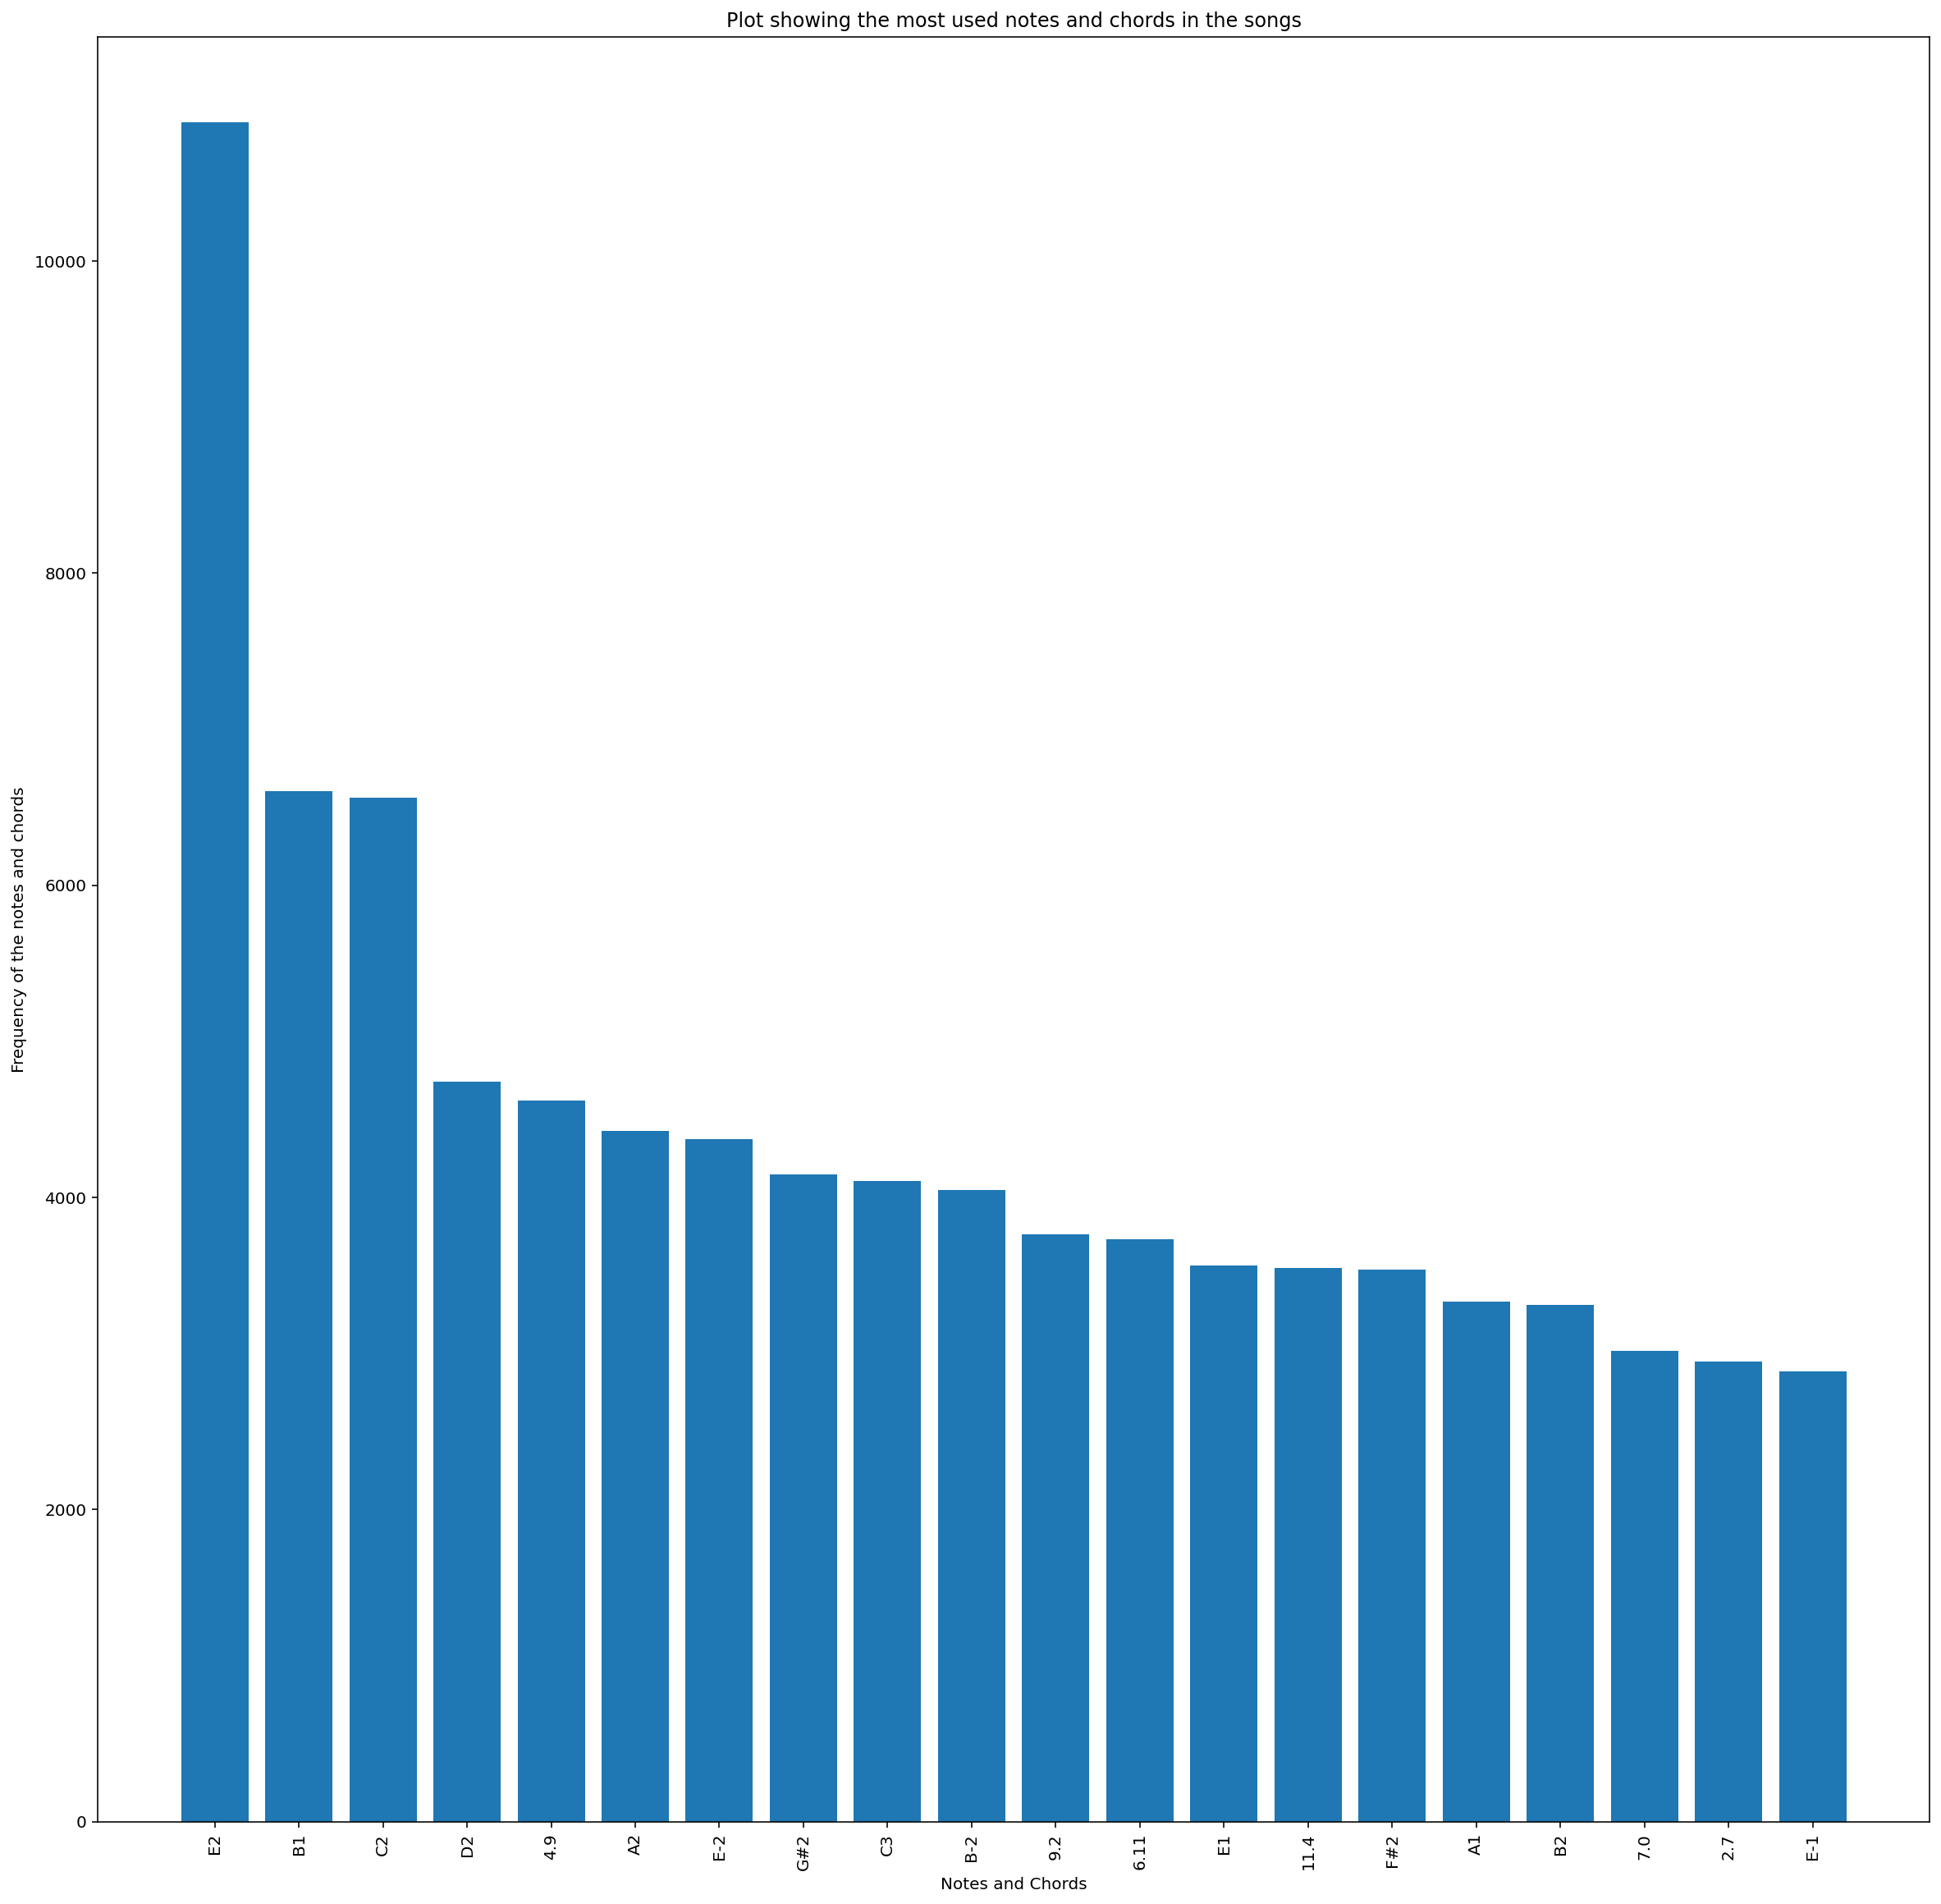

In [21]:
def note_plot(notes):
    note_dict = dict(Counter(notes))   #notes are converted into their respective dictionary
    note_dict = dict(sorted(note_dict.items(), key=operator.itemgetter(1),reverse=True)[:20]) # The top 20 notes and their frequency are taken as a dictionary

    #plot the graph
    fig, ax = plt.subplots(figsize=(20,20))  
    plt.bar(range(len(note_dict)), list(note_dict.values()), align='center')
    plt.xlabel('Notes and Chords')
    plt.ylabel('Frequency of the notes and chords')
    plt.title('Plot showing the most used notes and chords in the songs')
    plt.xticks(range(len(note_dict)), list(note_dict.keys()),rotation='vertical')
    plt.savefig('note_frequency.png')
    plt.show()

note_plot(notes)

## Plot to visualize the most used instruments

/home/aqshay/conda/envs/dml/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 0 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aqshay/conda/envs/dml/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 0 missing from current font.
  font.set_text(s, 0, flags=flags)


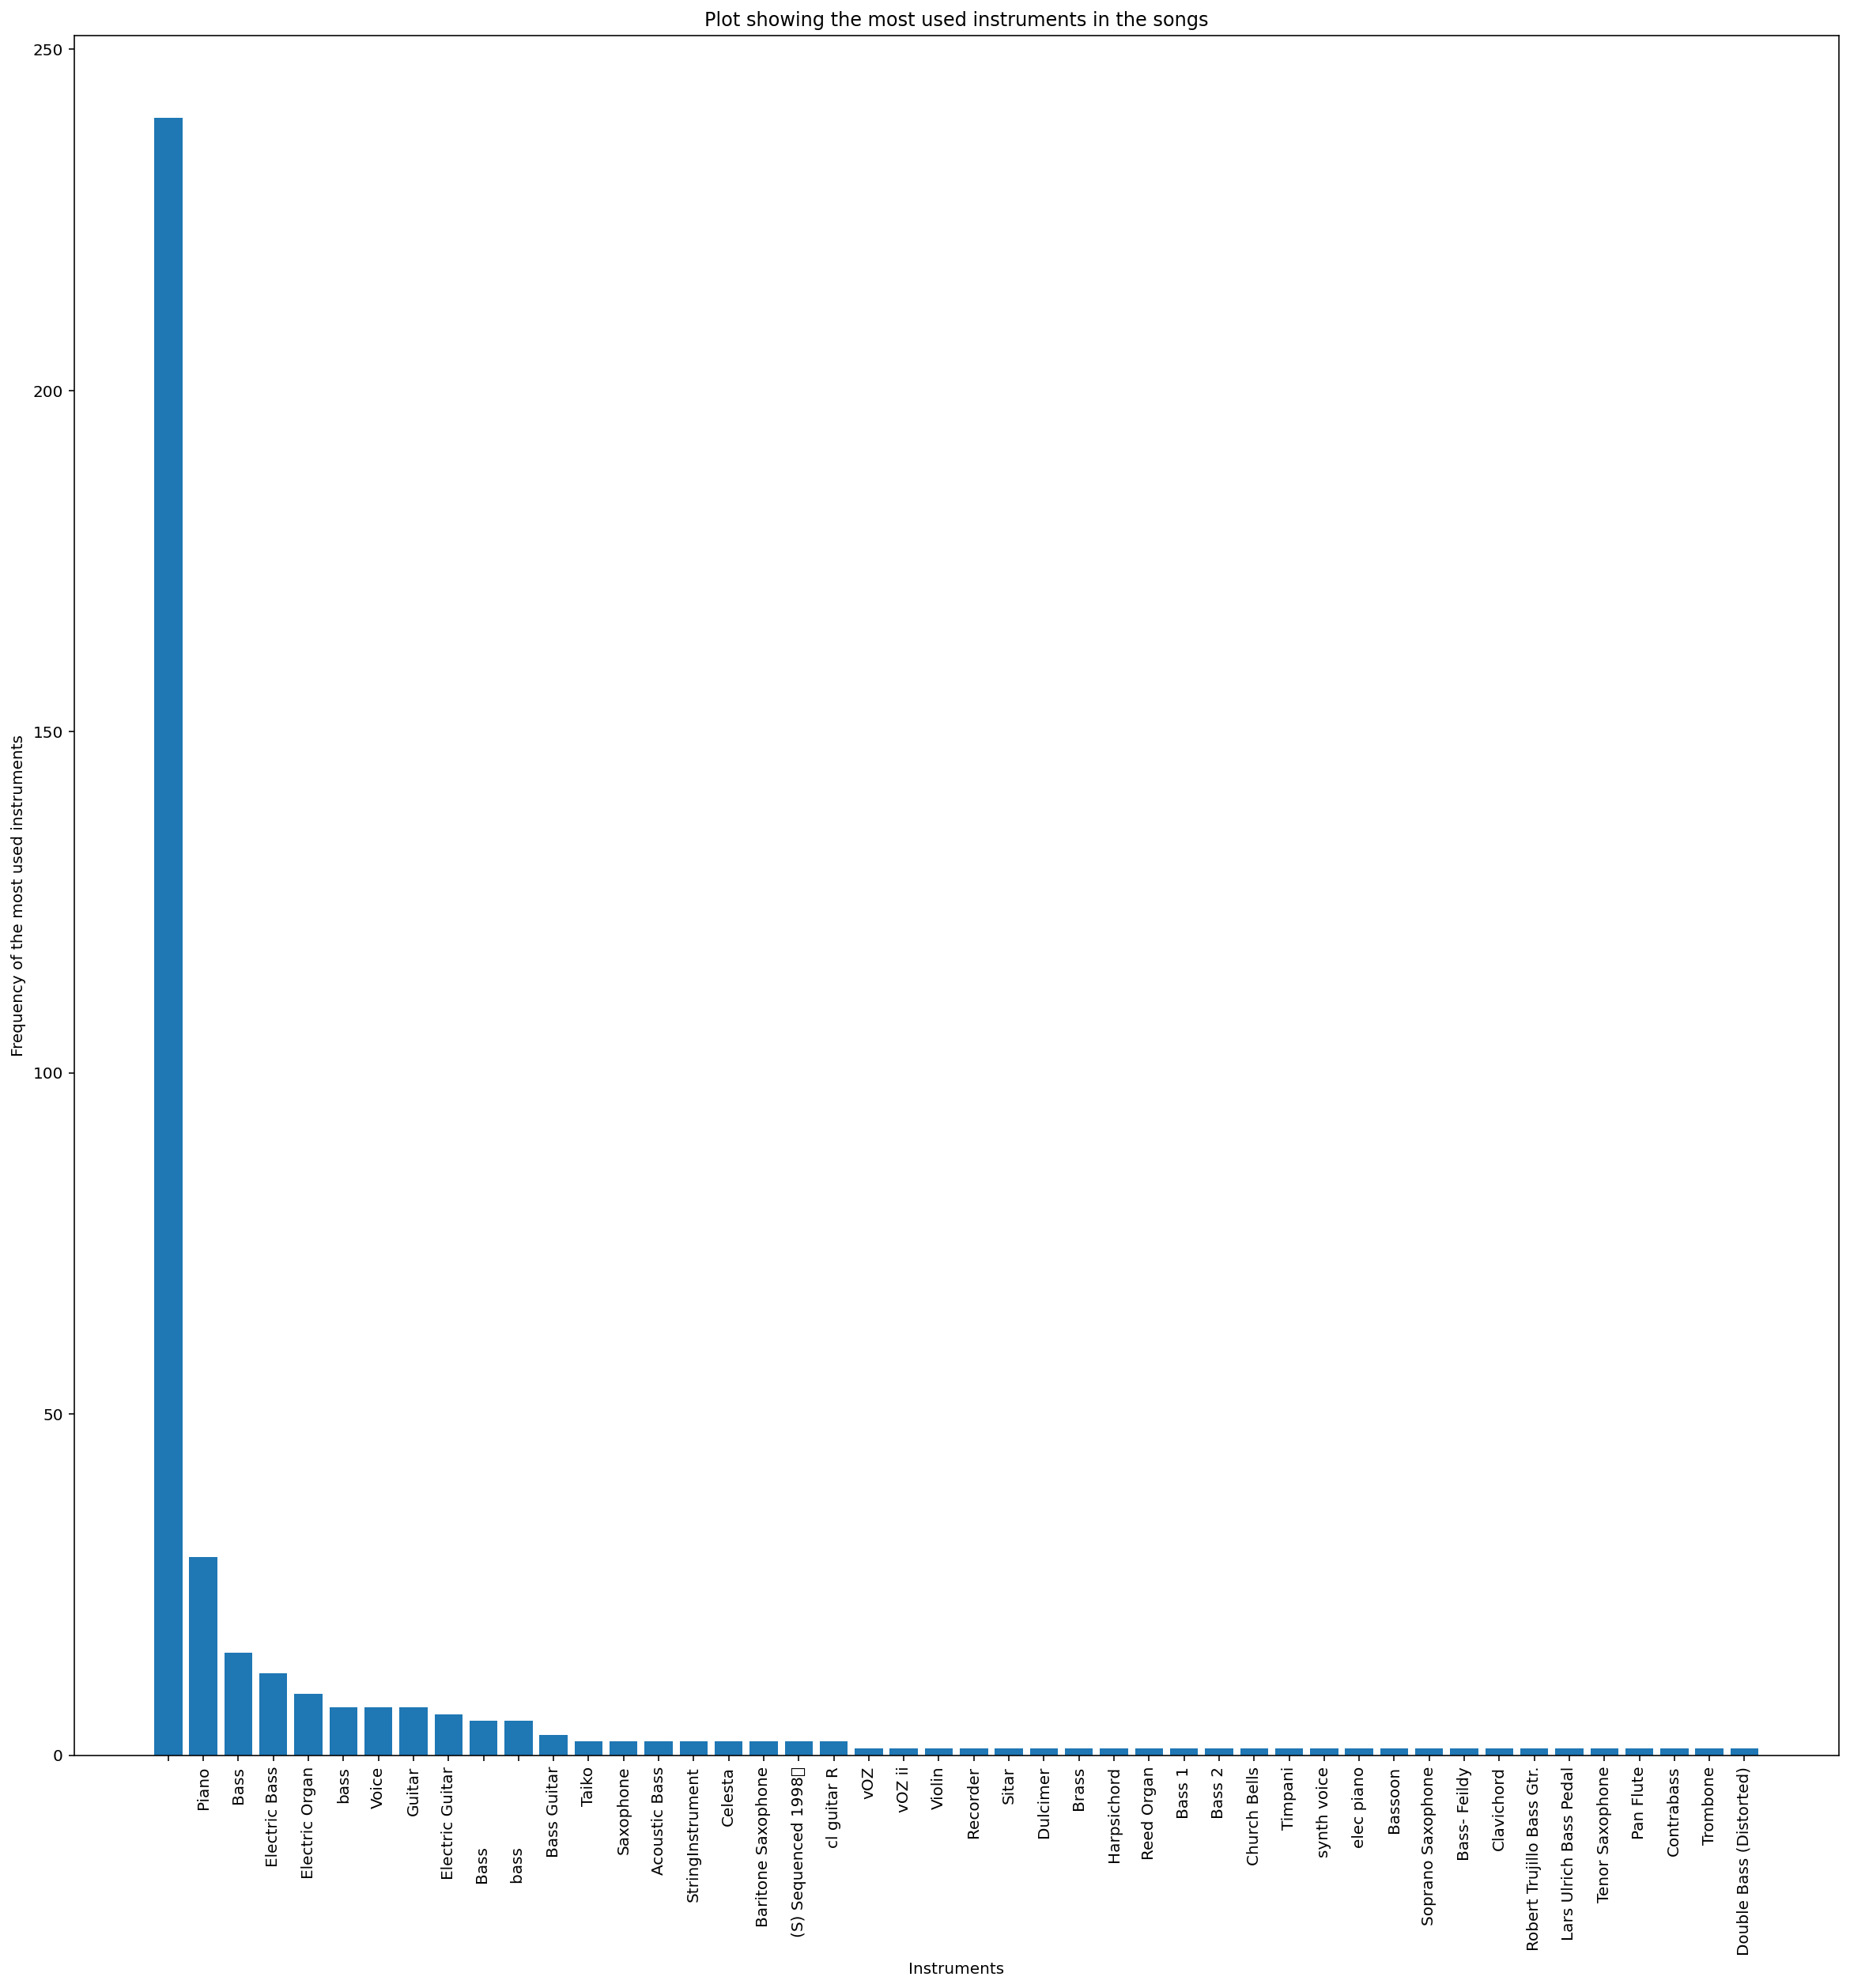

In [22]:
parts = []
for i in songs: #Get the instrument parts from the songs
    midi = converter.parse(i)
    partStream = midi.parts.stream()
    for p in partStream:
        aux = p
        parts.append(p.partName)  

def instrument_plot(parts):
    instruments = dict(Counter(parts)) #parts are converted into dictionary 
    instruments = dict(sorted(instruments.items(), key=operator.itemgetter(1),reverse=True)) #the dictionary is sorted in descending order
    fig, ax = plt.subplots(figsize=(20,20))  
    plt.bar(range(len(instruments)), list(instruments.values()), align='center')
    plt.xticks(range(len(instruments)), list(instruments.keys()),rotation='vertical')
    plt.xlabel('Instruments')
    plt.ylabel('Frequency of the most used instruments')
    plt.title('Plot showing the most used instruments in the songs')
    plt.savefig('instrument.png')
    plt.show()

instrument_plot(parts)

## Get the unique notes from a song

In [70]:
file = 'Metal Midi/blind.mid'
new_notes = parse_songs(file)
note_dict = dict(Counter(new_notes))   #notes are converted into their respective dictionary
print('Number of unique notes and chords in the song:',len(note_dict))

Metal Midi/blind.mid
Number of unique notes and chords in the song: 98


## Visualize the song in the form of piano roll

The number of unique pitches in the song: 61


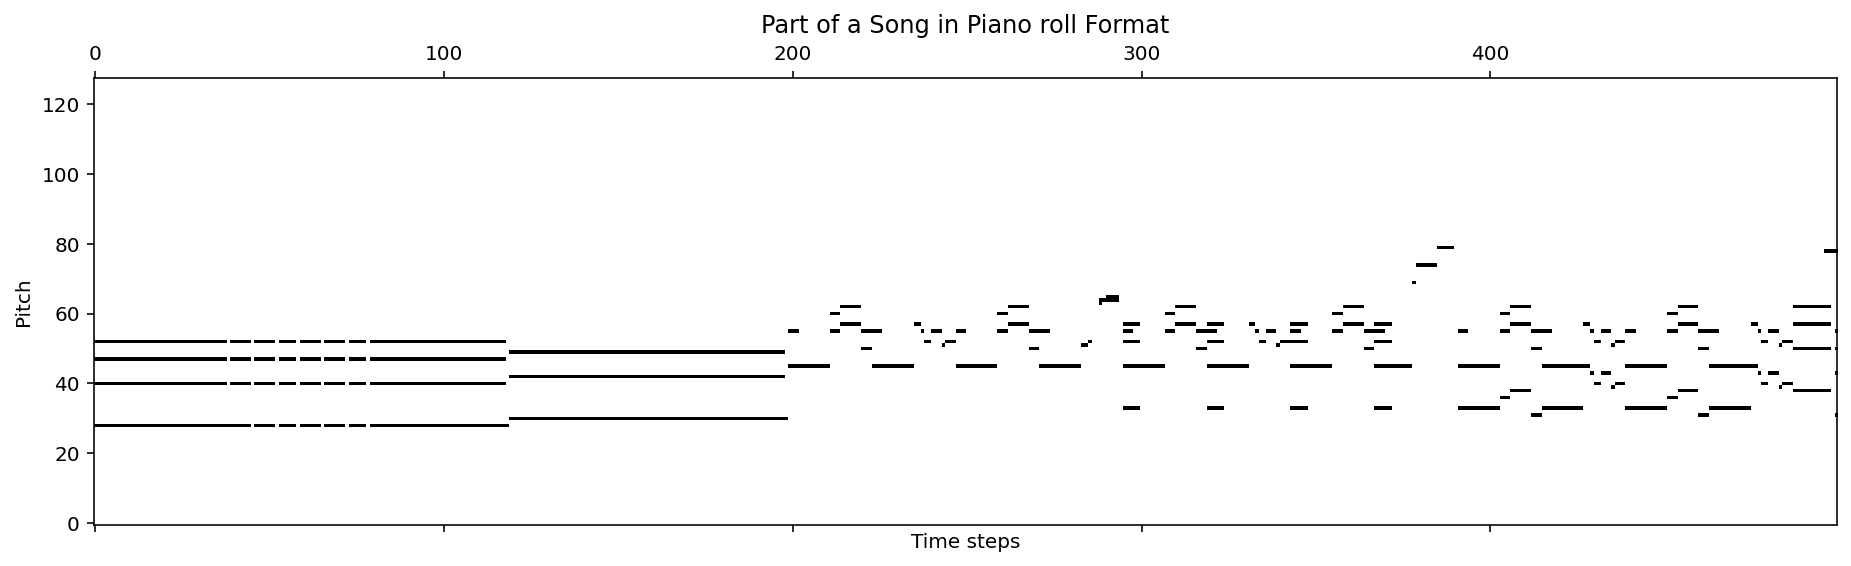

In [24]:
sampling_rate = 16

def generate_combine_piano_roll(midi_data, fs, program=None): #Function to generate piano roll format for the input song
    mat = None
    for inst in midi_data.instruments:
        inst.remove_invalid_notes() #removes the invalid notes in the song
        if inst.is_drum == False and (program is None or inst.program == program):
            inst_mat = inst.get_piano_roll(fs=fs) 
            if mat is None:
                mat = inst_mat
            elif inst_mat.shape == mat.shape:
                mat += inst_mat
            elif inst_mat.shape[1] < mat.shape[1]:
                inst_mat = np.pad(inst_mat, ((0,0),(0,mat.shape[1]-inst_mat.shape[1])), mode='constant')
                mat += inst_mat
            else:
                mat = np.pad(mat, ((0,0),(0,inst_mat.shape[1] - mat.shape[1])), mode='constant')
                mat += inst_mat
    
    if mat is None:
        return None
    
    mat[mat > 0] = 1
    return mat.T


def plot_pianoroll(FILE):
    midi_data = pretty_midi.PrettyMIDI(FILE)
    new_mat = generate_combine_piano_roll(midi_data, sampling_rate)
    mat= new_mat[:500,:] #changing the time steps to visualize the piano roll format
    matrix_new = new_mat.sum(axis=0) #To find the unique pitches in the song
    print("The number of unique pitches in the song:",np.count_nonzero(matrix_new))
    
    cax = plt.matshow(mat.T, aspect="auto", vmin=0, vmax=1, cmap="gray_r")
    plt.gca().invert_yaxis()
    plt.title('Part of a Song in Piano roll Format')
    plt.xlabel('Time steps')
    plt.ylabel('Pitch')
    plt.savefig('pianoroll.png')
    plt.show()
    
    
FILE  = 'Metal Midi/01.Metallica-Hit The Lights.mid'
plot_pianoroll(FILE)

## Pre-Processing

In [10]:
sequence_length = 35

# get all pitch names
pitchnames = sorted(set(item for item in notes))

# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

network_input = []
network_output = []

# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
n_patterns = len(network_input)

# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))

# normalize input
network_input = network_input / float(len(pitchnames))
network_output = np_utils.to_categorical(network_output)

## Model Definition

In [13]:
model = Sequential()
model.add(LSTM(128,input_shape=(network_input.shape[1], network_input.shape[2]),return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(len(pitchnames)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['categorical_accuracy'])

## Model Training

In [14]:

 checkpoint = ModelCheckpoint(
    'model_weight.h5', monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]     
final_model=model.fit(network_input, network_output, epochs=100, batch_size=128, shuffle= True, callbacks=callbacks_list, validation_split = 0.2)

Epoch 1/100
293/293 [==============================] - 26s 88ms/step - loss: 4.1245 - categorical_accuracy: 0.0753 - val_loss: 4.9710 - val_categorical_accuracy: 0.0036
Epoch 2/100
293/293 [==============================] - 25s 85ms/step - loss: 3.9227 - categorical_accuracy: 0.1025 - val_loss: 4.9477 - val_categorical_accuracy: 0.0041
Epoch 3/100
293/293 [==============================] - 25s 85ms/step - loss: 3.7887 - categorical_accuracy: 0.1150 - val_loss: 5.0007 - val_categorical_accuracy: 0.0089
Epoch 4/100
293/293 [==============================] - 25s 86ms/step - loss: 3.6359 - categorical_accuracy: 0.1417 - val_loss: 5.2477 - val_categorical_accuracy: 0.0152
Epoch 5/100
293/293 [==============================] - 25s 85ms/step - loss: 3.3715 - categorical_accuracy: 0.1991 - val_loss: 5.3153 - val_categorical_accuracy: 0.0280
Epoch 6/100
293/293 [==============================] - 25s 85ms/step - loss: 3.1282 - categorical_accuracy: 0.2436 - val_loss: 5.6299 - val_categorical_acc

## Plotting the Training and Loss for the model

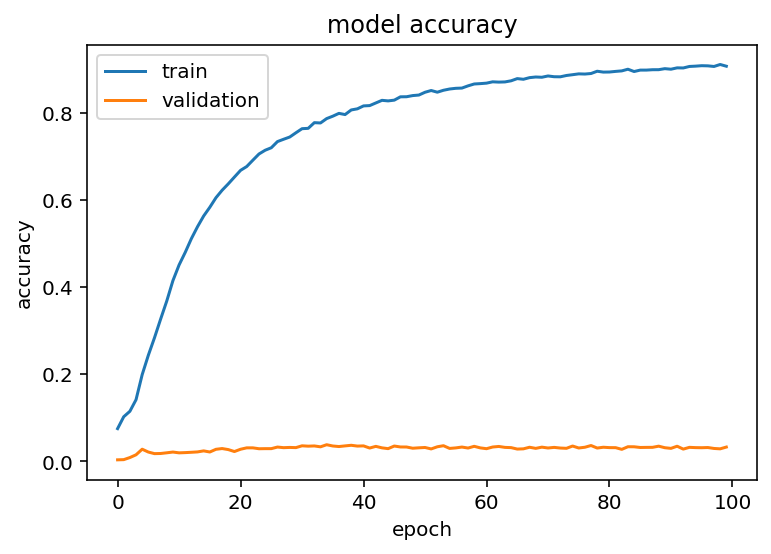

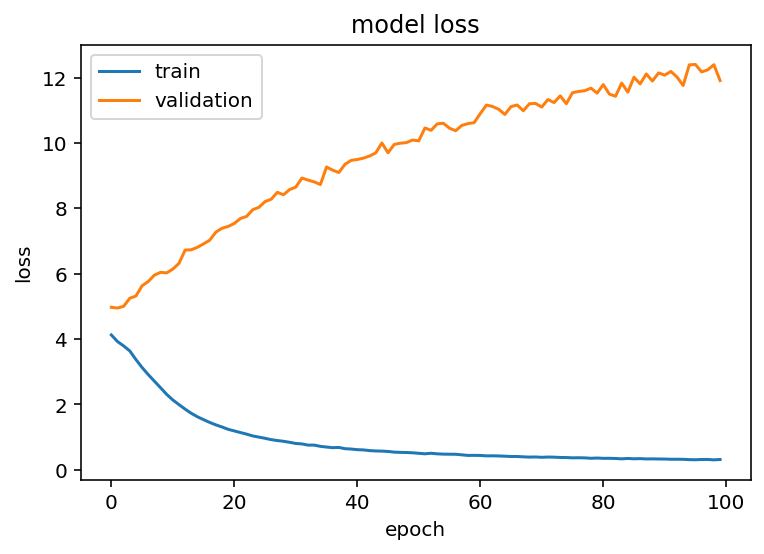

In [69]:
# summarize history for accuracy
plt.plot(final_model.history['categorical_accuracy'])
plt.plot(final_model.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('accuracy.png')
plt.show()

# summarize history for loss
plt.plot(final_model.history['loss'])
plt.plot(final_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Loss.png')
plt.show()

In [25]:
# Load the weights to each node
model.load_weights('model_weight.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 35, 128)           66560     
_________________________________________________________________
dropout_3 (Dropout)          (None, 35, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 35, 128)           131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 35, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4480)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1147136   
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)              

## Generating the notes

In [42]:
start = np.random.randint(0, len(network_input)-1) # Randomly select a starting point to generate a song 
int_to_note = dict((number, note) for number, note in enumerate(pitchnames)) #Creating a dictionary with the pitchnames
pattern = network_input[start]
prediction_output = []

#generate 3000 notes
#Predict the output based on the input pattern that is passed
for note_index in range(3000):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction = model.predict(prediction_input, verbose=0)
    index = np.argmax(prediction)
    result = int_to_note[index]
    prediction_output.append(result)   #The generated notes are appended one by one at each time step
    pattern = np.append(pattern,prediction[0,index])
    pattern = pattern[1:len(pattern)]  # 1 note in the beginning is left each time when a new note is added at the end

## Generating the output music in form of a single instrument

In [71]:
offset=0
output_notes=[]

#Create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord=pattern.split('.')
        notes=[]
        for current_note in notes_in_chord:
            output_notes.append(instrument.Piano()) #Passing the instrument name (Piano)
            cn=int(current_note) 
            new_note=note.Note(cn)
            notes.append(new_note)

        new_chord=chord.Chord(notes)
        new_chord.offset=offset
        output_notes.append(new_note)

     #Pattern is a note
    else:
        output_notes.append(instrument.Piano())
        new_note=note.Note(pattern)
        new_note.offset=offset
        output_notes.append(new_note)
    offset += 0.5

## Converting the output into midi file

In [72]:
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='latest.mid')
output_song = 'latest.mid' #Nwely generated song

## Evaluation


# Plot to display the most used notes and chords for the output song

latest.mid


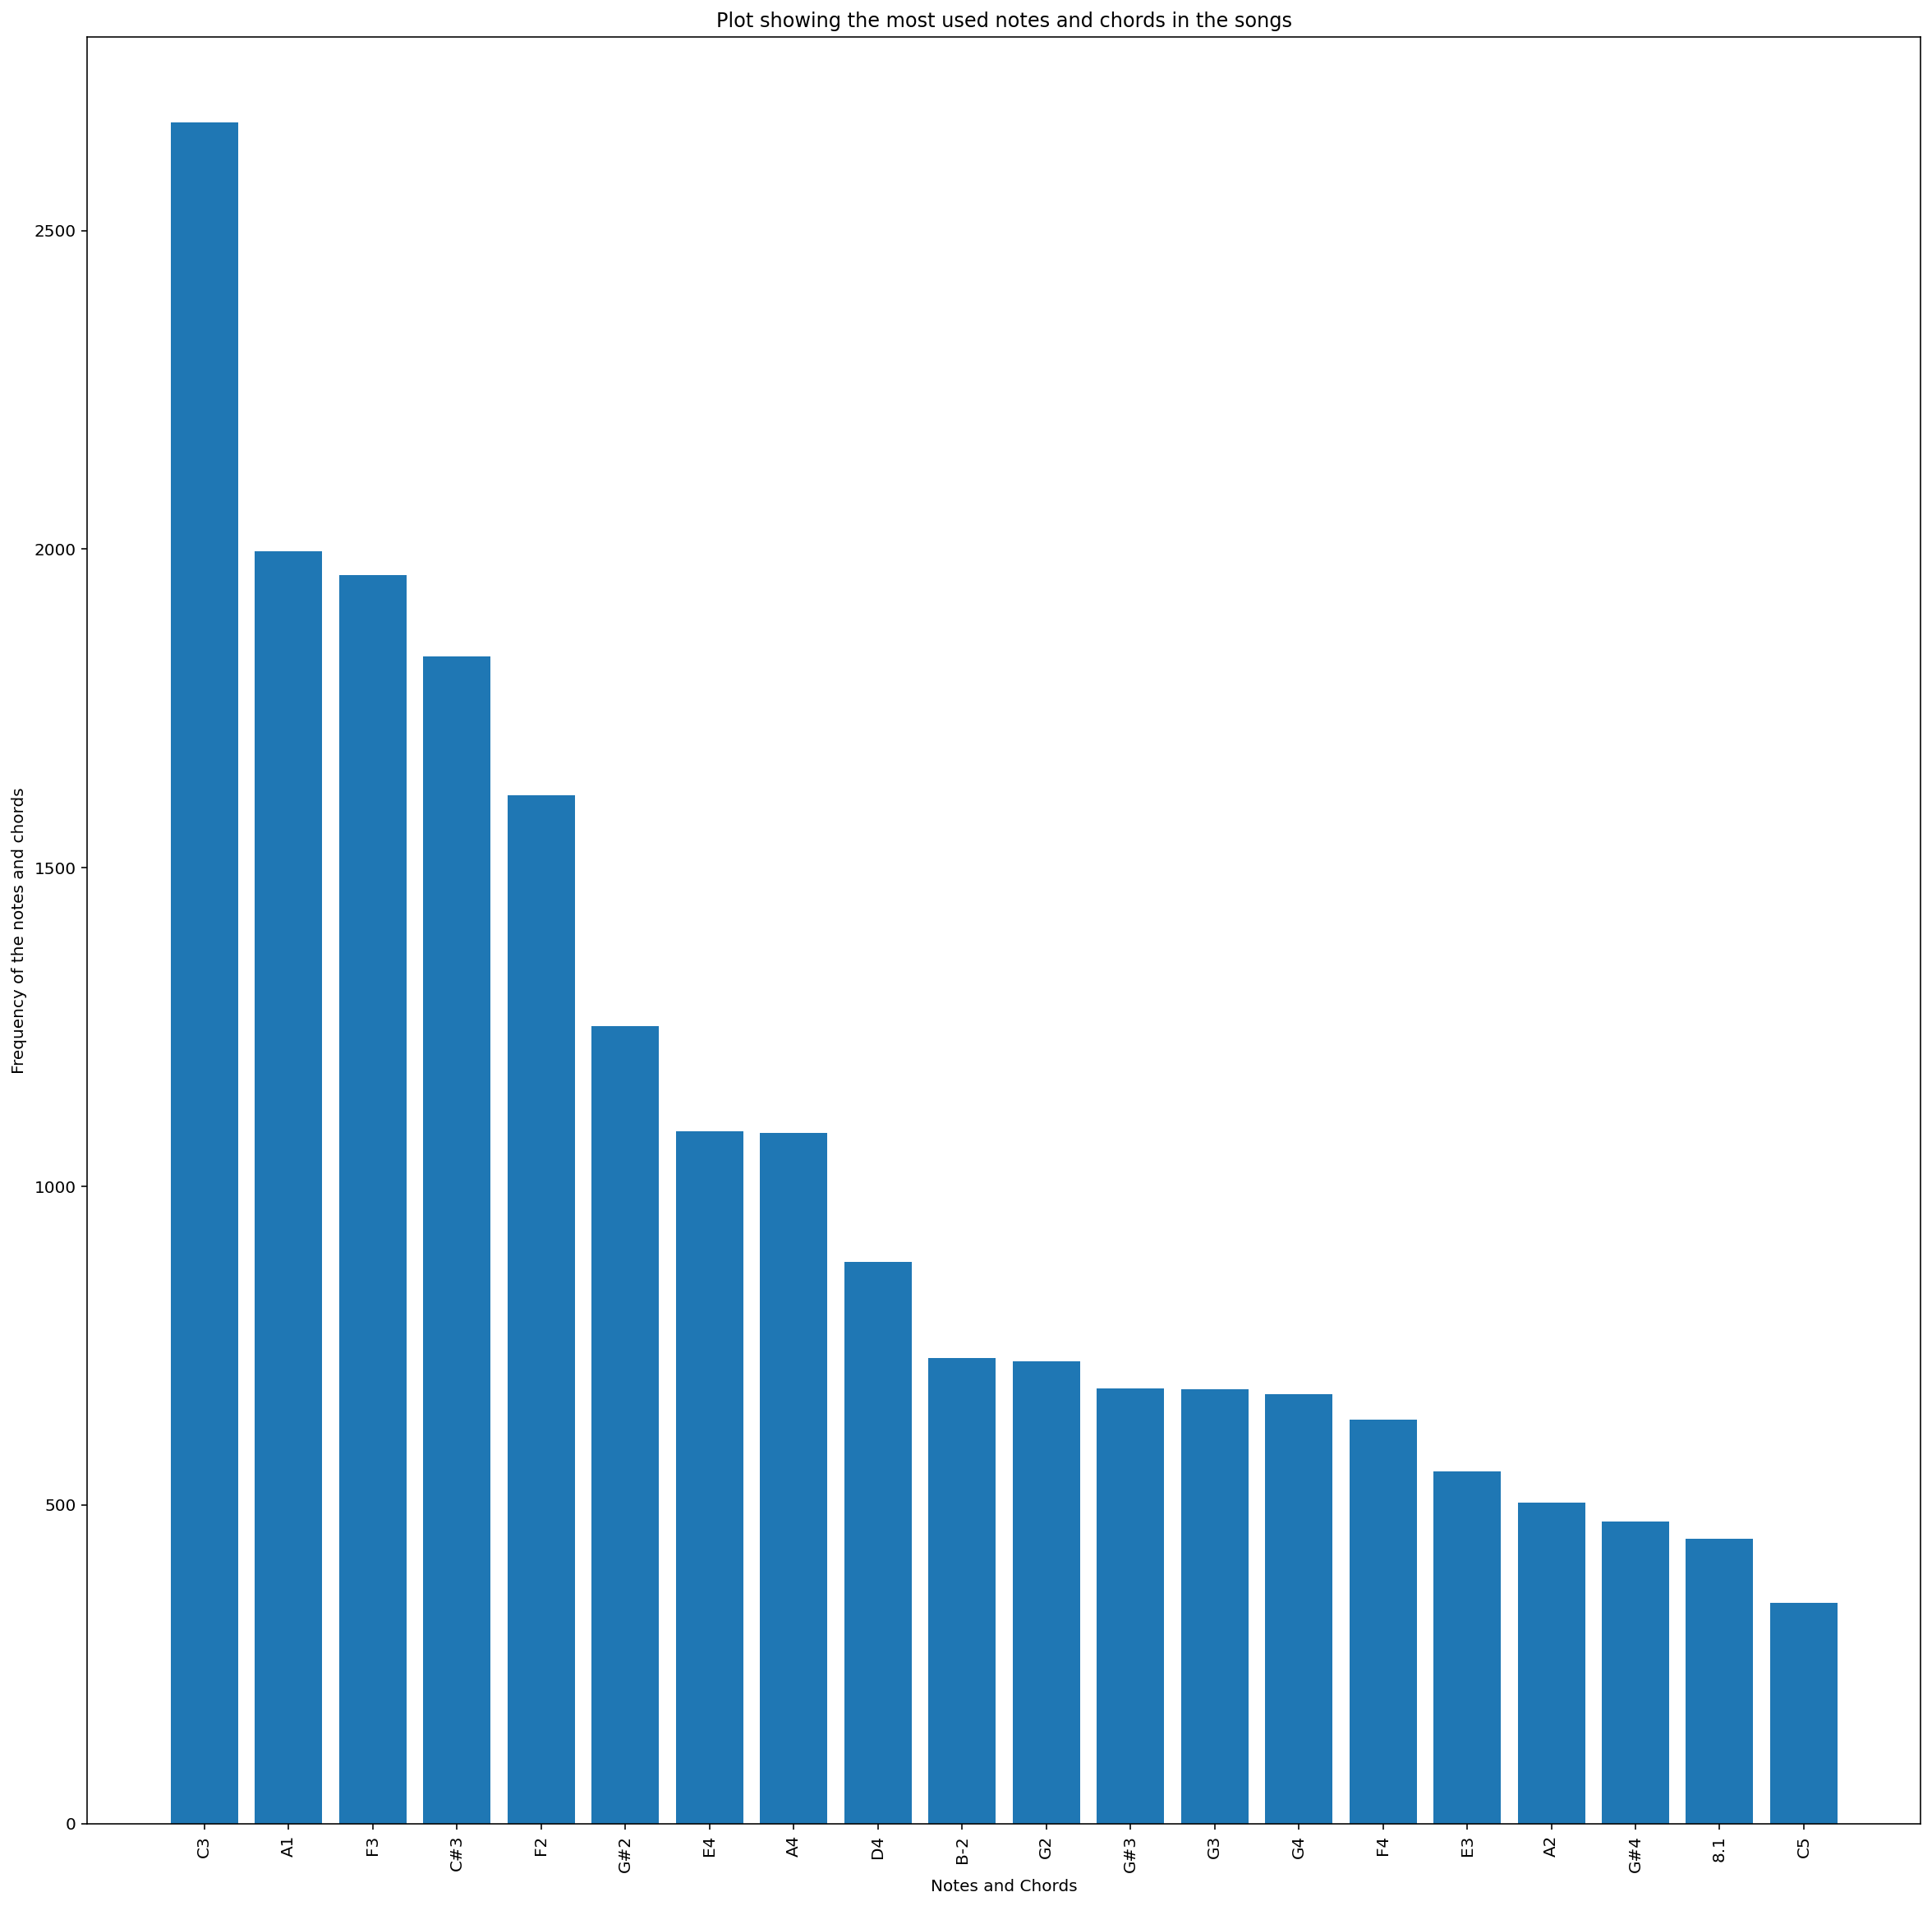

In [61]:
output_notes = parse_songs(output_song)
output_notes = output_notes[2:]
note_plot(output_notes)

# Plot to display the output song in the form of piano roll and get the unique pitches

Number of unique notes and chords 79
The number of unique pitches in the song: 54


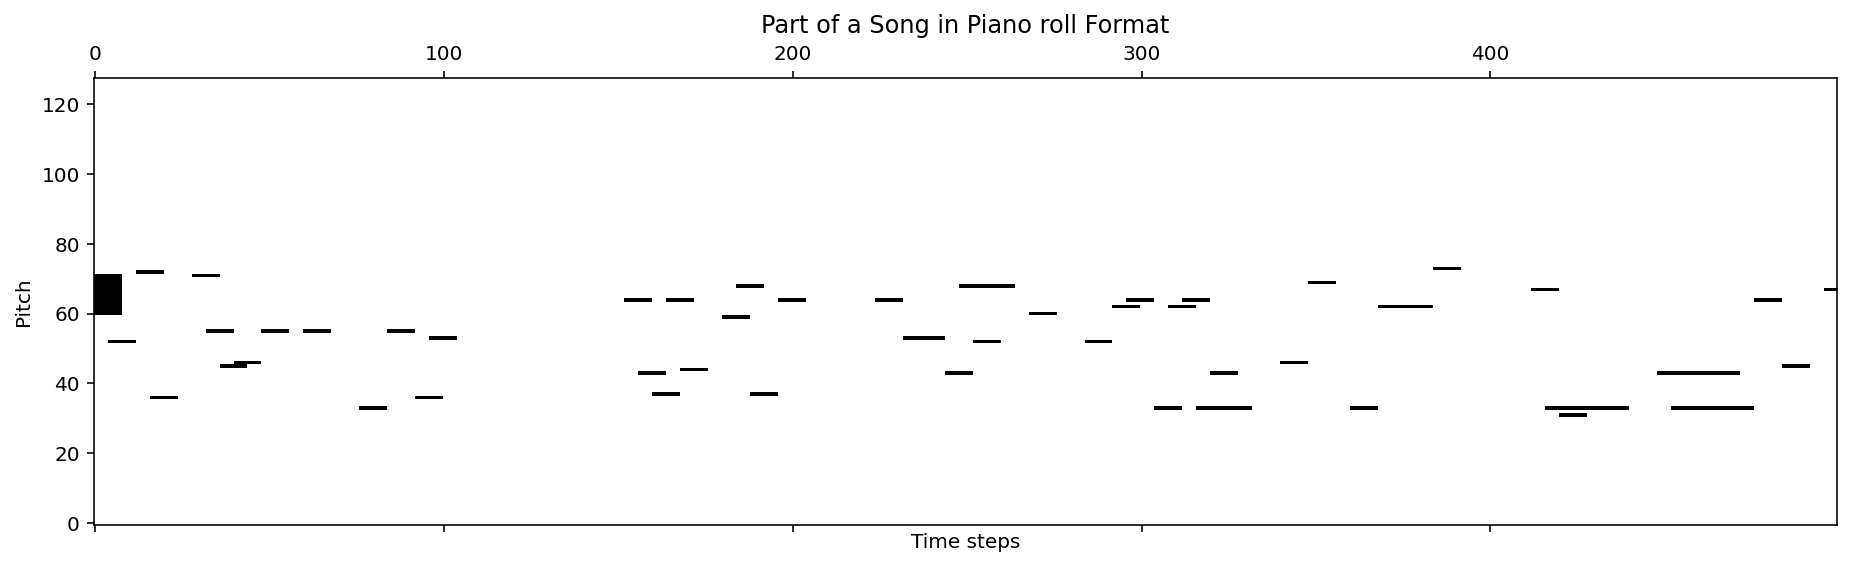

In [68]:
output_dict = dict(Counter(output_notes))   #notes are converted into their respective dictionary
print('Number of unique notes and chords',len(output_dict))
plot_pianoroll(output_song)

## Results

 Number of Unique Notes and Chords in one of the training samples : 98
<br>Number of Unique Notes and Chords in the generated music sample : 79
<br> Number of Unique Pitches in one of the training samples : 61
<br> Number of Unique Pitches in the generated music sample : 54

## To listen to the output song using Pygame library

In [5]:
import pygame

def play_music(midi_filename):
  '''Stream music_file in a blocking manner'''
  clock = pygame.time.Clock()
  pygame.mixer.music.load(midi_filename)
  pygame.mixer.music.play()
  while pygame.mixer.music.get_busy():
    clock.tick(30) # check if playback has finished
    
midi_filename = 'latest.mid'

# mixer config
freq = 44100  # audio CD quality
bitsize = -16   # unsigned 16 bit
channels = 2  # 1 is mono, 2 is stereo
buffer = 1024   # number of samples
pygame.mixer.init(freq, bitsize, channels, buffer)

# optional volume 0 to 1.0
pygame.mixer.music.set_volume(0.8)

# listen for interruptions
try:
  # use the midi file you just saved
  play_music(midi_filename)
except KeyboardInterrupt:
  # if user hits Ctrl/C then exit
  # (works only in console mode)
  pygame.mixer.music.fadeout(1000)
  pygame.mixer.music.stop()
  raise SystemExit

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "<ipython-input-5-2c9e626c9429>", line 26, in <module>
    play_music(midi_filename)
  File "<ipython-input-5-2c9e626c9429>", line 9, in play_music
    clock.tick(30) # check if playback has finished
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "E:\Anaconda3\envs\dml\lib\site-packages\IPython\core\interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-2c9e626c9429>", line 32, in <module>
    raise SystemExit
SystemExit

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "E:\Anaconda3\envs\dml\lib\site-packages\IPython\core\ultratb.py", line 1169, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "E:\Anaconda3\envs\dml\lib\site-packages\IPython\core\ultratb.py", line 316, in wrapped
    

TypeError: object of type 'NoneType' has no len()

In [ ]:
\